In [ ]:
# load required packages

!pip install pydub

import wave
import math
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import wave
import pandas as pd
import numpy as np
import pydub
from scipy.io.wavfile import read
from pydub import AudioSegment
from pydub.utils import make_chunks
from os import walk
from os import listdir
from os.path import isfile, join
import random
import seaborn as sns
from sklearn.pipeline import Pipeline
%matplotlib inline
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split,cross_validate,RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score,precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler,normalize,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold,GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from numpy.linalg import eigh
from sklearn.svm import SVC
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from datetime import datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# mount google drive to access files and folders

from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# load the data

audiopath_df = pd.DataFrame(columns=['file','audio_class'])
cwd = os.getcwd()
folder = ['belly_pain', 'burping','discomfort','hungry','tired']
for t in folder:
  folder_path = cwd+'/gdrive/MyDrive/DS5500/audio/'+t
  audiofile_path = [folder_path+'/'+file for file in os.listdir(folder_path) if file.endswith('.wav')]
  file_df=pd.DataFrame({'file':audiofile_path,
                  'audio_class':t})
  audiopath_df = pd.concat([audiopath_df, file_df],ignore_index=True)

In [ ]:
# dataframe snippet

audiopath_df

,file,audio_class
0,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain
1,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain
2,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain
3,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain
4,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain
...,...,...
452,/content/gdrive/MyDrive/DS5500/audio/tired/B2A...,tired
453,/content/gdrive/MyDrive/DS5500/audio/tired/b4c...,tired
454,/content/gdrive/MyDrive/DS5500/audio/tired/B2A...,tired
455,/content/gdrive/MyDrive/DS5500/audio/tired/79F...,tired


In [ ]:
# extract length of file, age and gender of babies from the files and append to the dataframe

def calculate_audio_length(file_path):
    # load audio file using file path and calculate the length of audio in minutes
    y,sr = librosa.load(file_path)
    length = len(y)/sr
    return length

def extract_gender(file_path):
    # extract information on gender from file name
    g = file_path.split("-")[-3]
    if g == "m":
        return "Male"
    else: return "Female"

def extract_age(file_path):
    # extract information on age in month from file name
    a = int(file_path.split("-")[-2])
    return a

In [ ]:
# extract length, gender and age using above functions

audiopath_df["length"] = audiopath_df["file"].map(lambda x:calculate_audio_length(x))
audiopath_df["gender"] = audiopath_df["file"].map(lambda x:extract_gender(x))
audiopath_df["age_in_months"] = audiopath_df["file"].map(lambda x:extract_age(x))

In [ ]:
# dataframe snipet
audiopath_df.head(6)

,file,audio_class,length,gender,age_in_months
0,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain,6.84,Male,4
1,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain,7.00,Male,26
2,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain,7.00,Male,72
3,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain,7.00,Male,72
4,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain,6.82,Male,4
5,/content/gdrive/MyDrive/DS5500/audio/belly_pai...,belly_pain,7.00,Male,72


In [ ]:
# function for audio feature extraction

def processing_audio(audio_df = audiopath_df.head(), n_second = 1):
    gender = []
    age = []
    cry_reason = []
    mfccs = []
    spectral_centriod = []
    spectral_flatness = []
    spectral_contrast = []
    spectral_rolloff = []
    chroma_features = []
    audio_index = []
    for idx , f in enumerate(audio_df["file"]):
        y, s = librosa.load(f)
        gender.append(f.split("-")[-3])
        age.append(f.split("-")[-2])
        cry_reason.append(audio_df["audio_class"][idx])

        # Start from dividing the sound signal into the form of frames with a duration of 1-seconds
        f1 = y[len(y)-6*s:]

        # Extract Mel-frequency cepstral coefficients (MFCCs) to represent the short-term power spectrum of sound.
        mfcc = librosa.feature.mfcc(y=f1, sr=s, n_mfcc=19)
        mfccs.append(mfcc)
        # Extract Spectral Centriod
        cent = librosa.feature.spectral_centroid(y=f1, sr=s)
        spectral_centriod.append(cent)
        # Extract Spectral flatness
        flat = librosa.feature.spectral_flatness(y=f1)
        spectral_flatness.append(flat)
        # Extract Spectral contrast
        S = np.abs(librosa.stft(f1))
        sc = librosa.feature.spectral_contrast(S=S, sr=s)
        spectral_contrast.append(sc)
        # Extract Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=f1, sr=s)
        spectral_rolloff.append(rolloff)
        # Extract Chroma Features
        cf = librosa.feature.chroma_stft(y=f1, sr=s)
        chroma_features.append(cf)
    output_df = pd.DataFrame({"gender" : gender,
                              "age" : age,
                              "cry_reason" : cry_reason,
                              "mfcc" : mfccs,
                              "spectral_centroid": spectral_centriod,
                              "spectral_flatness": spectral_flatness,
                              "spectral_contrast": spectral_contrast,
                              "spectral_rolloff" : spectral_rolloff,
                              "chroma_features": chroma_features})
    return output_df

In [ ]:
def convert_matrix_vector_to_df(matrix_vector):
    # convert a vector of matrix to a vector of arrays by flattening all nested arrays
    flatten_df = matrix_vector.flatten()
    return flatten_df

In [ ]:
def convert_matrix_to_columns(data, column_name):
    # if the first cell of the column is a matrix then convert this column into multiple columns by flattening the matrix
    df = data[column_name].map(lambda x:convert_matrix_vector_to_df(x))
    temp_df = pd.DataFrame(df.tolist(),index = df.index)
    temp_df.columns = [column_name + f'{c}' for c in temp_df.columns]
    data = pd.concat([data,temp_df],axis =1)
    data = data.drop([column_name], axis=1)
    return data

In [ ]:
def feature_extraction(file_path_df):
    data_df = processing_audio(audio_df = file_path_df, n_second = 1)
    #2-D acoustic features are converted into 1-d vector before passing as input in the next process by flattening.
    flatten_data_df = data_df.copy()
    for column_name in data_df.columns:
        if type( data_df[column_name][0]) != str and not isinstance(data_df[column_name][0], (int, np.integer)) and (data_df[column_name][0].shape[0]*data_df[column_name][0].shape[1]>1):
            flatten_data_df = convert_matrix_to_columns(flatten_data_df, column_name)
    return data_df,flatten_data_df

In [ ]:
### Feature Extraction
data_df, flatten_data_df = feature_extraction(audiopath_df)

In [ ]:
print(data_df.columns)
print(data_df['mfcc'][0].shape)
print(data_df['spectral_centroid'][0].shape)
print(data_df['spectral_flatness'][0].shape)
print(data_df['spectral_contrast'][0].shape)
print(data_df['spectral_rolloff'][0].shape)
print(data_df['chroma_features'][0].shape)

Index(['gender', 'age', 'cry_reason', 'mfcc', 'spectral_centroid',
       'spectral_flatness', 'spectral_contrast', 'spectral_rolloff',
       'chroma_features'],
      dtype='object')
(19, 259)
(1, 259)
(1, 259)
(7, 259)
(1, 259)
(12, 259)


In [ ]:
# check the datatypes of all columns
flatten_data_df.dtypes

gender                  object
age                     object
cry_reason              object
mfcc0                  float32
mfcc1                  float32
                        ...   
chroma_features3103    float32
chroma_features3104    float32
chroma_features3105    float32
chroma_features3106    float32
chroma_features3107    float32
Length: 10622, dtype: object

In [ ]:
# convert age column to numerical, OHE for gender column

flatten_data_df['age'] = flatten_data_df['age'].astype('int')
data_df_dummies = pd.get_dummies(data=flatten_data_df, columns =['gender'], drop_first = True)
data_df_dummies

,age,cry_reason,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,chroma_features3099,chroma_features3100,chroma_features3101,chroma_features3102,chroma_features3103,chroma_features3104,chroma_features3105,chroma_features3106,chroma_features3107,gender_m
0,4,belly_pain,-303.195190,-324.722565,-349.721832,-334.005768,-318.959259,-318.602692,-331.212585,-345.276398,...,0.109998,0.095484,0.053695,0.045574,0.031871,0.066851,0.302777,0.377039,0.275251,1
1,26,belly_pain,-419.254364,-417.083466,-421.269379,-406.788544,-395.728424,-402.286407,-310.538025,-221.291916,...,0.044957,0.189168,0.463238,0.708028,0.306205,0.198445,0.288251,0.402418,0.307809,1
2,72,belly_pain,-487.922150,-463.824707,-457.248077,-461.868896,-464.413086,-462.844269,-466.436188,-469.829620,...,1.000000,1.000000,0.738450,1.000000,1.000000,0.935964,0.990787,0.714619,0.875135,1
3,72,belly_pain,-361.462708,-351.338013,-368.665375,-375.510040,-332.961945,-279.833466,-254.689407,-243.369324,...,0.282597,0.347589,0.683270,0.754689,0.598723,0.682885,0.407737,0.556980,0.440984,1
4,4,belly_pain,-549.613953,-530.328491,-529.352661,-514.341431,-500.933319,-492.842896,-496.989075,-495.120270,...,0.310468,0.349430,0.444307,0.698461,0.648197,0.296407,0.352633,0.300238,0.207001,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,26,tired,-177.404083,-212.619812,-296.071625,-312.547668,-310.680817,-312.888916,-327.447388,-333.357239,...,0.119671,0.136507,0.140646,0.072134,0.025075,0.034831,0.058641,0.041986,0.017207,1
453,26,tired,-312.534943,-314.081238,-335.880249,-332.214447,-322.999084,-323.235657,-324.540771,-322.679474,...,0.000374,0.000368,0.000464,0.000576,0.001190,0.001330,0.002796,0.003502,0.011109,0
454,26,tired,-395.574158,-374.671387,-382.511139,-389.785187,-397.935852,-394.739258,-394.656433,-395.165924,...,0.408239,0.272419,0.779001,1.000000,1.000000,0.785337,0.729391,0.434745,0.615268,1
455,48,tired,-473.554810,-444.218414,-437.840485,-433.915497,-432.319885,-428.080139,-414.913116,-405.586212,...,0.152676,0.142157,0.325596,0.358577,0.273618,0.172317,0.350205,0.367770,0.278456,0


Data Viz

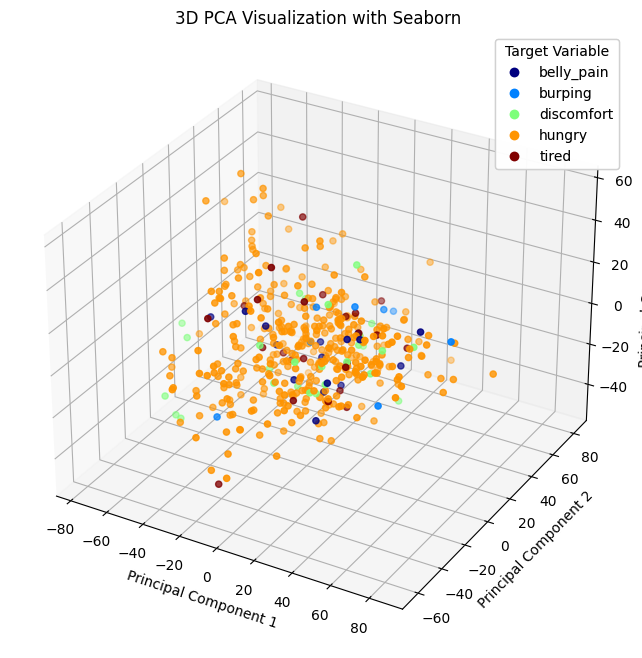

In [ ]:
# Show first two principal components with scaler
vizy = data_df_dummies['cry_reason']
vizX = data_df_dummies.drop(['cry_reason'], axis=1)

# label encoding
le = LabelEncoder()
y_le = to_categorical(le.fit_transform(vizy))
y_le = np.argmax(y_le, axis = 1)

pipe = Pipeline([('stdscaler', StandardScaler()), ('vizpca', PCA(n_components=3))])
vizdata = pipe.fit_transform(vizX)

# Create a new DataFrame with the principal components and target variable
pca_df = pd.DataFrame(vizdata, columns=["PC1", "PC2","PC3"])
pca_df["target_variable"] = vizy

# Plot 3D PCA visualization with Seaborn
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter3D(pca_df["PC1"], pca_df["PC2"], pca_df["PC3"], c=y_le, cmap="jet")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D PCA Visualization with Seaborn")
handles, _ = scatter.legend_elements(num=[0, 1, 2, 3, 4])
legend = ax.legend(handles,le.classes_, title="Target Variable")
ax.add_artist(legend)
plt.show()

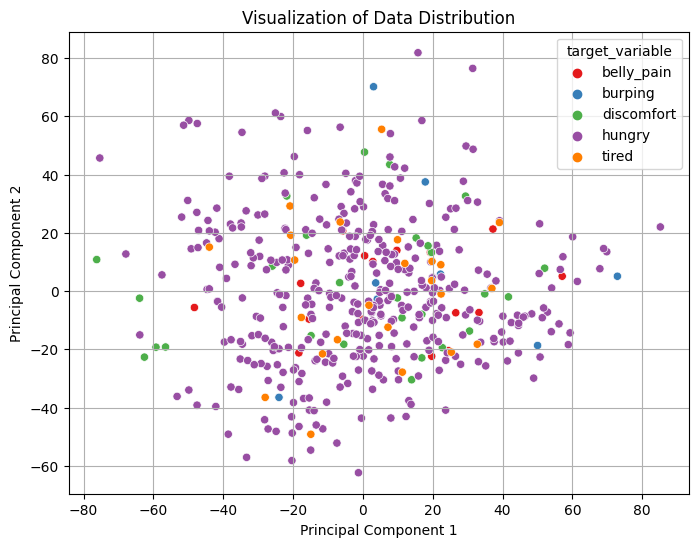

In [ ]:

# Plot PCA visualization with Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="target_variable", palette="Set1")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Visualization of Data Distribution")
plt.grid(True)
plt.show()


In [ ]:
import plotly.express as px
fig = px.scatter_3d(
    pca_df, x=pca_df['PC1'], y=pca_df['PC2'], z=pca_df['PC3'], color=pca_df['target_variable'],
    title = 'Interactive 3D plot for Data Vizualization')

fig.show()

In [ ]:
def derive_pc(X_train,X_test):
    # input: X matrix
    # output: principal components that explain at least 90% of the variance

    # Standardize X_train and X_test for classification
    sc = StandardScaler()
    X_train_standardized = sc.fit_transform(X_train)
    X_test_standardized = sc.transform(X_test)

    # Calculate principal components
    pca = PCA(n_components= 2)
    pca.fit(X_train_standardized)
    X_train_pc = pca.transform(X_train_standardized)
    X_test_pc = pca.transform(X_test_standardized)

    return X_train_pc, X_test_pc


In [ ]:
def smote(X_train, y_train):
    #Use SMOTE to oversample the minority class
    oversample = SMOTE()
    over_X_train, over_y_train = oversample.fit_resample(X_train, y_train)
    return over_X_train, over_y_train

In [ ]:
def svm(X_train, X_test, y_train, y_test):
    # Derive principal components of X_train and X_test
    X_train_pc, X_test_pc = derive_pc(X_train, X_test)

    print('X_train_pc shape',X_train_pc.shape)
    print('X_test_pc shape',X_test_pc.shape)

    # label encoding
    le = LabelEncoder()
    y_train = to_categorical(le.fit_transform(y_train))
    y_test = to_categorical(le.transform(y_test))

    #print('le done')
    # Create the hyperparameter grid
    #kernels: calculate the similarity or distance between pairs of data points and transform data to higher dimensional space
    #gamma: determines the influence of a single training point. Mostly used for non-linear kernels like RBF
    #C: it is the regularization paramerter which determines penalty for misclassifying training examples.
    #degree: determines the degree of the polynomial used to compute the kernel function in case of polynomial kernel
    param_grid = [{'kernel': ['rbf','poly','sigmoid'],
                    'gamma': [1e-2,1e-3],
                    'C': [1,10,100],
                    'degree':[2,3]}]

    # Set the base model with class_weight as balanced
    svm_model = SVC(class_weight='balanced')
    #print('svm_model')
    # Find the hyperparameter combination that returns the best result
    svm_grid_model = GridSearchCV(estimator = svm_model,
                                        param_grid = param_grid,
                                        refit=True, # refit the model with best paramter on the dataset
                                        cv = 2,# 2-fold cross validation,
                                        verbose=2,# the computation time for each fold, parameter candidate, and the score are displayed
                                        n_jobs = -1) #using all processor

    # get the max prob class so input is 1D array
    y_train = np.argmax(y_train, axis = 1)

    # fit the model
    svm_grid_model.fit(X_train_pc, y_train)
    print('model fit done')

    # Get the best SVM classifier from the grid search
    svm_best_model = svm_grid_model.best_estimator_
    print('best params',svm_grid_model.best_params_)

    # get test predictions
    predictions = svm_best_model.predict(X_test_pc)

    # we apply inverse of label encoder to get the corresponding lables of the numeric values
    y_pred_labels = le.inverse_transform(predictions)
    print('inverse done')


    return y_pred_labels

In [ ]:
def svm_smote(X_train, X_test, y_train, y_test):

    # Derive principal components of X_train and X_test
    X_train_pc, X_test_pc = derive_pc(X_train, X_test)

    # apply smote to address class imbalance by oversampling minority class
    over_X_train, over_y_train = smote(X_train_pc, y_train)

    print('X_train_smote shape',over_X_train.shape)
    print('y_teain_smote shape',over_y_train.shape)

    print('X_test shape',X_test_pc.shape)

    # label encoding
    le = LabelEncoder()
    y_train = to_categorical(le.fit_transform(over_y_train))
    y_test = to_categorical(le.transform(y_test))

    # Create the hyperparameter grid
    #kernels: calculate the similarity or distance between pairs of data points and transform data to higher dimensional space
    #gamma: determines the influence of a single training point. Mostly used for non-linear kernels like RBF
    #C: it is the regularization paramerter which determines penalty for misclassifying training examples.
    #degree: determines the degree of the polynomial used to compute the kernel function in case of polynomial kernel

    param_grid = [{'kernel': ['rbf','poly','sigmoid'],
                    'gamma': [1e-2,1e-3],
                    'C': [1,10,100],
                    'degree':[2,3]}]

    # Set the base model with class_weight as balanced
    svm_model = SVC()

    # Find the hyperparameter combination that returns the best result
    svm_grid_model_optimal = GridSearchCV(estimator = svm_model,
                                          param_grid = param_grid,
                                          refit=True,     # refit the model with best paramter on the dataset
                                          cv = 2,         # 2-fold cross validation,
                                          verbose=2,      # the computation time for each fold, parameter candidate, and the score are displayed
                                          n_jobs = -1)    #using all processor

    # get the max prob class so input is 1D array
    y_train = np.argmax(y_train, axis = 1)

    # fit the model
    svm_grid_model_optimal.fit(over_X_train, y_train)

    # Get the best SVM classifier from the grid search
    svm_best_model = svm_grid_model_optimal.best_estimator_
    print('best params:', svm_grid_model_optimal.best_params_)

    # get test predictions
    predictions = svm_best_model.predict(X_test_pc)

    # we apply inverse of label encoder to get the corresponding lables of the numeric values
    y_pred_labels = le.inverse_transform(predictions)

    return y_pred_labels

In [ ]:
# Define function for reporting performance metrics

def report_performance(y_test,y_pred):
    # calculate precision, recall, and f1 based on the cry reason of orginal audio and predictions
    precision_1, recall_1,f1_1, null_value_1 = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)

    precision_2, recall_2,f1_2, null_value_2 = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
    # calucate accuracy rate
    accuracy = accuracy_score(y_test,y_pred)
    return {
        'precision_macro': precision_1,
        'recall_macro': recall_1,
        'f1_macro': f1_1,
        'precision_weighted': precision_2,
        'recall_weighted': recall_2,
        'f1_weighted': f1_2,
        'accuracy': accuracy
    }

In [ ]:
# Prep your inputs to the model, train test split

y = data_df_dummies['cry_reason']
X = data_df_dummies.drop(['cry_reason'], axis = 1)

print(X.shape)
print(y.shape)

# train-test-val split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(y_train.shape)
print(y_test.shape)

(457, 10621)
(457,)
(365, 10621)
(92, 10621)
(365,)
(92,)
(365,)
(92,)


In [ ]:
# execute the model and get predictions

models = ['svm(X_train, X_test, y_train, y_test)',
          'svm_smote(X_train, X_test, y_train, y_test)'
          ]
for model in models:
  y_pred = eval(model)

  # calculate performance metrics
  metrics_dict = report_performance(y_test,y_pred)
  if model== models[0]:
    metrics_df = pd.Series(metrics_dict).to_frame().T
    metrics_df['model_name'] = model.split('(')[0]
  else:
    temp_df = pd.Series(metrics_dict).to_frame().T
    temp_df['model_name'] = model.split('(')[0]
    metrics_df = pd.concat([metrics_df, temp_df],axis = 0)

metrics_df

X_train_pc shape (365, 2)
X_test_pc shape (92, 2)
Fitting 2 folds for each of 36 candidates, totalling 72 fits
model fit done
best params {'C': 100, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
inverse done
X_train_smote shape (1550, 2)
y_teain_smote shape (1550,)
X_test shape (92, 2)
Fitting 2 folds for each of 36 candidates, totalling 72 fits
best params: {'C': 100, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}


,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,accuracy,model_name
0,0.201765,0.209921,0.204202,0.648210,0.619565,0.632810,0.619565,svm
0,0.169231,0.061111,0.089796,0.662207,0.239130,0.351375,0.239130,svm_smote
